In [1]:
# Initialize libraries for visualization with IPython
%pylab inline

# Import some other libraries we will use explicitly
import h5py
import numpy as np
import scipy.signal as sp
import matplotlib.pyplot as plt
from obspy.signal.trigger import classic_sta_lta, trigger_onset, plot_trigger

Populating the interactive namespace from numpy and matplotlib


## Read in Data & get raw data

In [2]:
# The path to your file
fpath = './small_data_sample/North-C1-LR-P1kHz-GL50m-Sp2m-FS200Hz_2021-11-04T181202Z.h5'

# Open the file for reading
fp = h5py.File(fpath,'r')

# Print the keys for the top-level object in the file
print(fp.keys())

<KeysViewHDF5 ['Acquisition']>


In [25]:
# Create a new variable for the "RawData" h5py dataset
rawData = fp['Acquisition']['Raw[0]']['RawData']

trace = rawData[12300, :]

In [23]:
trace

array([[-544577489, -544579779, -544581409, ..., -543929226, -543924380,
        -543920267],
       [-362525490, -362527783, -362529718, ..., -362152268, -362147959,
        -362142631]], dtype=int32)

## Test Obspy Signal

In [26]:
%%time
# get clst array
clst = classic_sta_lta(trace, 100, 6000)

# get list of trigger times
trigger_onset(clst, thres1=1.01, thres2=1.0)

[array([0.        , 0.        , 0.        , ..., 1.00484409, 1.00482547,
       1.00480686])]
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.1 ms


array([[ 8137,  9209],
       [11427, 11999]])

In [4]:
# get clst array
clst = classic_sta_lta(trace, 100, 6000)

# plot trigger onset using 15 on threshold, 10 off threshold (same as paper)
# come back to this error (have to initialize trace as Trace object)
plot_trigger(trace, clst, 15, 10)

AttributeError: 'numpy.ndarray' object has no attribute 'stats'

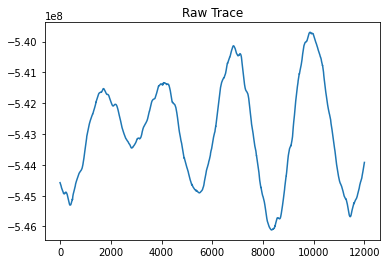

In [20]:
plt.title("Raw Trace")
plt.plot(trace)
plt.show()

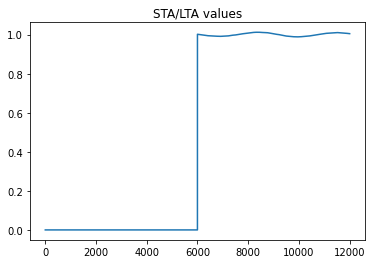

In [21]:
plt.title("STA/LTA values")
plt.plot(clst)
plt.show()

Here we see that STA/LTA doesn't seem to register values other than 0 until after the full LTA period is complete. This poses a major problem given one minute samples we have.
Questions to ask: 
- Can we reconfigure times/thresholds for STA/LTA for our domain? What values are reasonable for STA/LTA length & threshold levels?
- Should we just stitch together a series of one-minute samples and keep same values? If we have to detrend data anyway, then this seems like most reasonable soln.
- Could buffering each channel with the same length as LTA be useful? Maybe use average or median of first LTA seconds as buffer? Or the reverse trace of first LTA seconds?

Separate questions about STA/LTA (more useful once discriminating whether we should include signal in list of disturbances):
- What is good heuristic for maximum length of triggerred signal? 

In [6]:
%%time
# get list of trigger times
trigger_onset(clst, thres1=1.01, thres2=1.0)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 2.05 ms


array([[ 6381,  7045],
       [ 7190,  7418],
       [ 9558,  9679],
       [10127, 11522]])

## Applying STA-LTA to full minute of data

Now that we have verified that the algorithm works for a single trace, we can apply the sta_lta algorithm to the full 

In [ ]:
def sta_lta(data, nsta, nlta):
    """
    Computes STA/LTA for full minute of data
    
    Inputs:
    - data (NumPy array): DAS recording for across multiple channels
    - nsta (int):  Length of short time average window in samples
    - nlta (int):  Length of long time average window in samples
    """
    num_channels = rawData.shape[0]
    sta_lta = [None] * num_channels

    for i in range(num_channels):
        trace_tmp = rawData[i, :]
        clst_tmp = classic_sta_lta(trace_tmp, nsta, nlta)
        sta_lta[i] = clst_tmp
        
    return sta_lta

def trigger_onsets(sta_lta, thres1=15, thres2=10, max_len=9e99, max_len_delete=False):
    """
    Computes Trigger Times for full DAS data
    """
    num_channels = sta_lta.shape[0]
    triggers = [None] * num_channels
    
    for i in range(num_channels):
        clst_tmp = sta_lta[i]
        triggers[i] = trigger_onset(clst_tmp, thres1=thres1, thres2=thres2, max_len=max_len, max_len_delete=max_len_delete)

In [17]:
%%time
num_channels = rawData.shape[0]
sta_lta = [None] * num_channels

for i in range(num_channels):
    trace_tmp = rawData[i, :]
    clst_tmp = classic_sta_lta(trace_tmp, 100, 6000)
    sta_lta[i] = clst_tmp

KeyboardInterrupt: 

In [7]:
%%time
# get trigger start & end times for entire minute of data
num_channels = rawData.shape[0]
full_triggers = [None] * num_channels
for i in range(num_channels):
    trace_tmp = rawData[i, :]
    clst_tmp = classic_sta_lta(trace_tmp, 100, 6000)
    triggers_tmp = trigger_onset(clst_tmp, thres1=15, thres2=10)
    full_triggers[i] = triggers_tmp

KeyboardInterrupt: 

Given length of time this takes to run, it might behoove us to downsample number of channels as well as frequency? 